# Exploratory data analysis 1

This notebook demonstrates that there are less images per lap with higher speeds and 
that the ground truth turning angles tend to have more extreme values with higher speeds.

## Setup
- Download and unpack training data
- Create DonkeyCar project and load configuration

In [3]:
%load_ext autoreload
%autoreload 2
!ls
import os
print(os.environ['CONDA_DEFAULT_ENV'])

CV_1_frame_CounterClockwise_direction_only.ipynb
CV_1_frame_mixed_directions_5_folds.ipynb
CV_3D_CNN_modified_CounterClockwise_direction_only.ipynb
EDA1.ipynb
LICENSE
README.md
TESTS_CV_1_frame_CC_direction_only_no_folds.ipynb
config
data
donkeycar
mycar
temp
test_and_code.ipynb
wandb
donkey2


In [4]:
![ ! -d "data/" ] && \
mkdir data && \
curl -L "https://www.dropbox.com/s/eltelvjt12a4ny1/data.zip?dl=1" --output data/data.zip && \
unzip data/data.zip -d data

In [5]:
![ ! -d "mycar/" ] && \
donkey createcar --path mycar && \
cp config/myconfig.py mycar/

In [6]:
import numpy as np
import donkeycar as dk
cfg = dk.load_config(config_path='mycar/config.py')

loading config file: mycar/config.py
loading personal config over-rides from myconfig.py


## Is the driving speed of .9 actually different from the slower speeds of .85 and .8?
Prove that the driving speed of .9 actually was faster by
showing that there are less images per lap with higher speeds using image difference graphs

### Load images

In [7]:
import os
from collections import OrderedDict

from donkeycar.pipeline.sequence import TubRecord
from donkeycar.pipeline.types import TubDataset

def load_tub_records(tub_path, cfg):
    dataset = TubDataset(cfg, [os.path.expanduser(tub_path)])
    records = []
    for tub in dataset.tubs:
        for underlying in tub:
            record = TubRecord(cfg, tub.base_path, underlying)
            records.append(record)
    return records

def load_tub_images(tub_path, cfg):
    return [r.image() for r in load_tub_records(tub_path, cfg)]

tubs = [
    '1-1-CC-80',
    '1-2-CC-90',
    '1-3-CC-85',
    '2-1-CW-80',
    '2-2-CW-90',
    '2-3-CW-85',
    '3-2-CW-90',
    '3-3-CW-85',
    '4-1-CC-80',
    '4-2-CC-90',
    '4-3-CC-85'
]

tub_images = OrderedDict()

for tub_path in tubs:
    full_path = 'data/' + tub_path
    images = load_tub_images(full_path, cfg)
    tub_images[tub_path] = images


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/1-1-CC-80/catalog_4.catalog
Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/1-2-CC-90/catalog_4.catalog
Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/1-3-CC-85/catalog_4.catalog
Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/2-1-CW-80/catalog_4.catalog
Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/2-2-CW-90/catalog_2.catalog
Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/2-3-CW-85/catalog_6.catalog
Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/3-2-CW-90/catalog_6.catalog
Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/3-3-CW-85/catalog_4.catalog
Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/4-1-CC-80/catalog_5.catalog
Using catalog /User

### Compare all the frames of the tub with first frame

In [71]:
def mse(image1, image2):
    return np.mean((image1 - image2) ** 2)

def rmse(image1, image2):
    return np.sqrt(mse(image1, image2))

def get_diffs(images):
    return [rmse(images[0], img) for img in images]

def get_counts(diffs, lower_bound=8.8, upper_bound=9.75):
    flip = False
    counts = []
    for i, d in enumerate(diffs):
        if not flip and d < lower_bound and (len(counts) == 0 or i - counts[-1] > 165):
            flip = True
            counts.append(i)
        if flip and d > upper_bound:
            flip = False
    return np.array(counts)

def get_lengths(counts):
    return counts[1:] - counts[:-1]

def get_lengths_and_mean(images, lower_bound, upper_bound):
    diffs = get_diffs(images)
    counts = get_counts(diffs, lower_bound, upper_bound)
    lengths = get_lengths(counts)
    return lengths, int(np.mean(lengths))

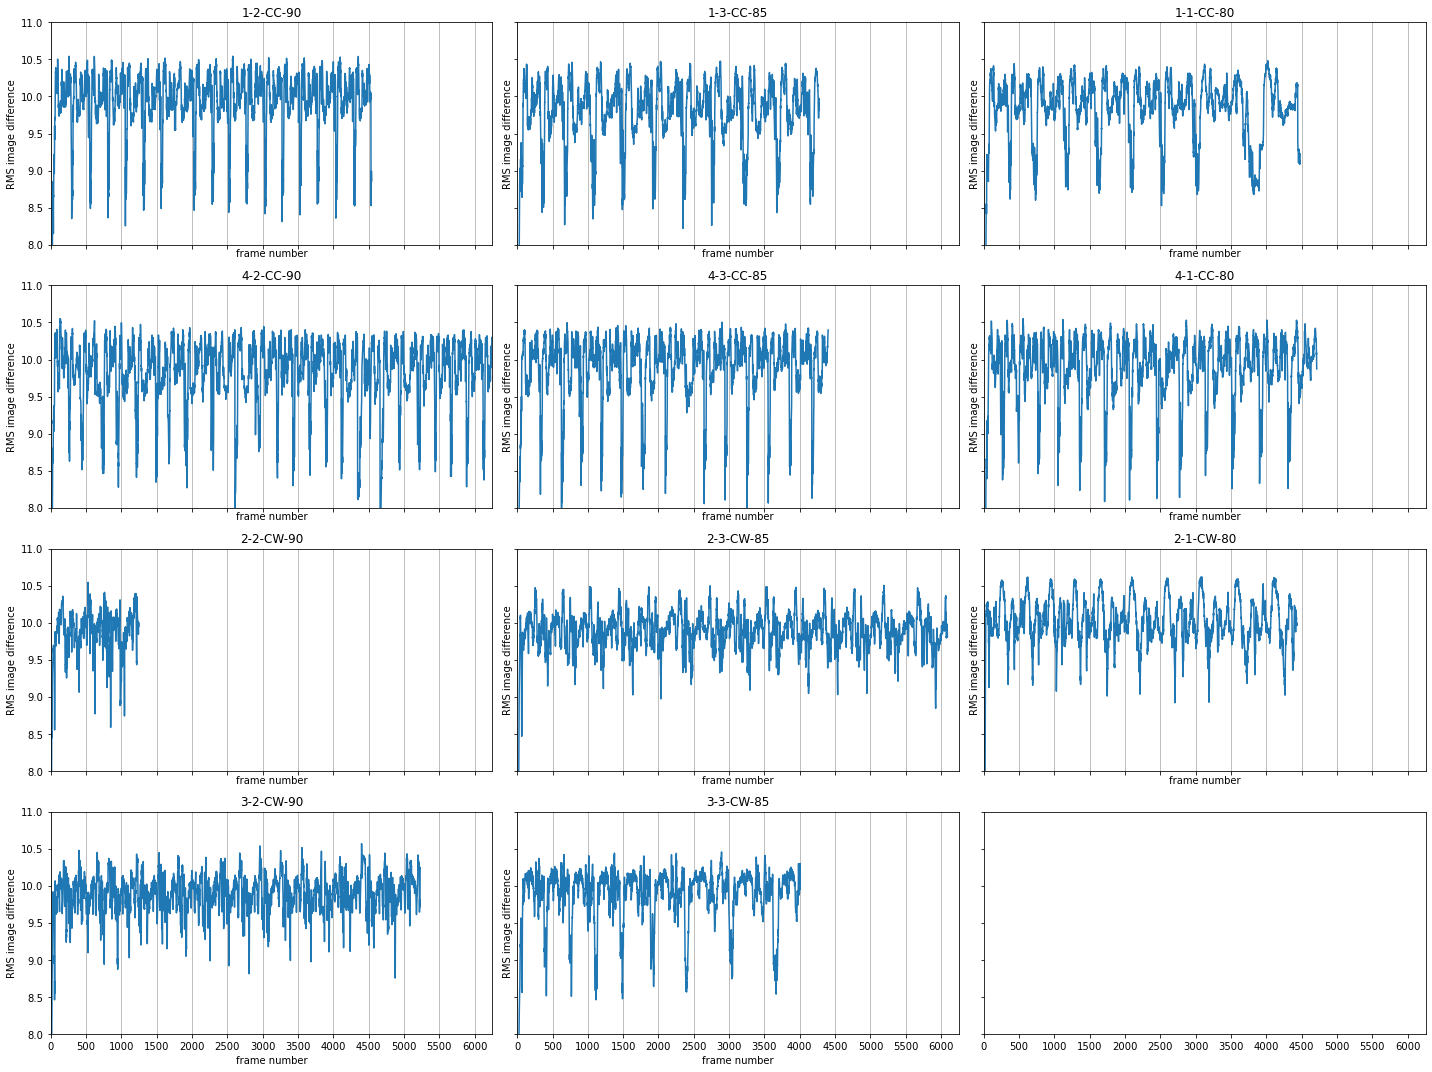

In [72]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [30/2.54, 25/2.54]
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 15), sharex='all', sharey='all')

for (name, (lower_bound, upper_bound)), ax in zip(tub_bounds, axs.flat):
    images = tub_images[name]
    diffs = get_diffs(images)
    ax.set(title=name, xlabel='frame number', ylabel='RMS image difference')
    ax.grid(True, axis='x')
    ax.plot(diffs)

max_image_counts = max(image_counts)
ax.set(ylim=(8, 11), xlim=(0, max_image_counts), xticks=range(0, max_image_counts, 500))
fig.tight_layout()
plt.show()


### Count the number of laps for each tub

In [73]:
tub_bounds = [
    ('1-2-CC-90',    (9.55, 10)),
    ('1-3-CC-85',    (8.8, 9.75)),
    ('1-1-CC-80',    (9.25, 10.1)),
    ('4-2-CC-90',    (8.8, 10)),
    ('4-3-CC-85',    (9.3, 10)),
    ('4-1-CC-80',    (8.75, 9.5)),
    ('2-2-CW-90',    (9.28, 10)),
    ('2-3-CW-85',    (9.35, 10.0)),
    ('2-1-CW-80',    (9.25, 10.4)),
    ('3-2-CW-90',    (9.25, 9.8)),
    ('3-3-CW-85',    (8.75, 10)),
]

average_lap_frames = {}
image_counts = []
lengths_counts = []


for name, (lower_bound, upper_bound) in tub_bounds:
    images = tub_images[name]
    image_counts.append(len(images))
    lengths, mean = get_lengths_and_mean(images, lower_bound, upper_bound)
    lengths_counts.append(lengths)
    average_lap_frames[name] = mean

average_lap_frames

{'1-2-CC-90': 251,
 '1-3-CC-85': 414,
 '1-1-CC-80': 494,
 '4-2-CC-90': 255,
 '4-3-CC-85': 297,
 '4-1-CC-80': 331,
 '2-2-CW-90': 197,
 '2-3-CW-85': 422,
 '2-1-CW-80': 425,
 '3-2-CW-90': 270,
 '3-3-CW-85': 456}

### Does the frames-per-lap count differ for different speeds?

In [74]:
from collections import defaultdict

speed_averages = defaultdict(list)

for tubname, lap_average in average_lap_frames.items():
    speed_averages[tubname[-2:]].append(lap_average)
speed_averages

defaultdict(list,
            {'90': [251, 255, 197, 270],
             '85': [414, 297, 422, 456],
             '80': [494, 331, 425]})

In [75]:
{k:int(np.mean(v)) for k,v in speed_averages.items()}

{'90': 243, '85': 397, '80': 416}

### How much data do we have for each speed?

In [76]:
speed_image_count = defaultdict(list)

for tubname, images in tub_images.items():
    print(tubname, len(images))
    speed_image_count[tubname[-2:]].append(len(images))
speed_image_count

1-1-CC-80 4480
1-2-CC-90 4546
1-3-CC-85 4276
2-1-CW-80 4433
2-2-CW-90 1249
2-3-CW-85 6090
3-2-CW-90 5233
3-3-CW-85 4008
4-1-CC-80 4713
4-2-CC-90 6253
4-3-CC-85 4402


defaultdict(list,
            {'80': [4480, 4433, 4713],
             '90': [4546, 1249, 5233, 6253],
             '85': [4276, 6090, 4008, 4402]})

In [77]:
{k: sum(v) for k,v in speed_image_count.items()}

{'80': 13626, '90': 17281, '85': 18776}

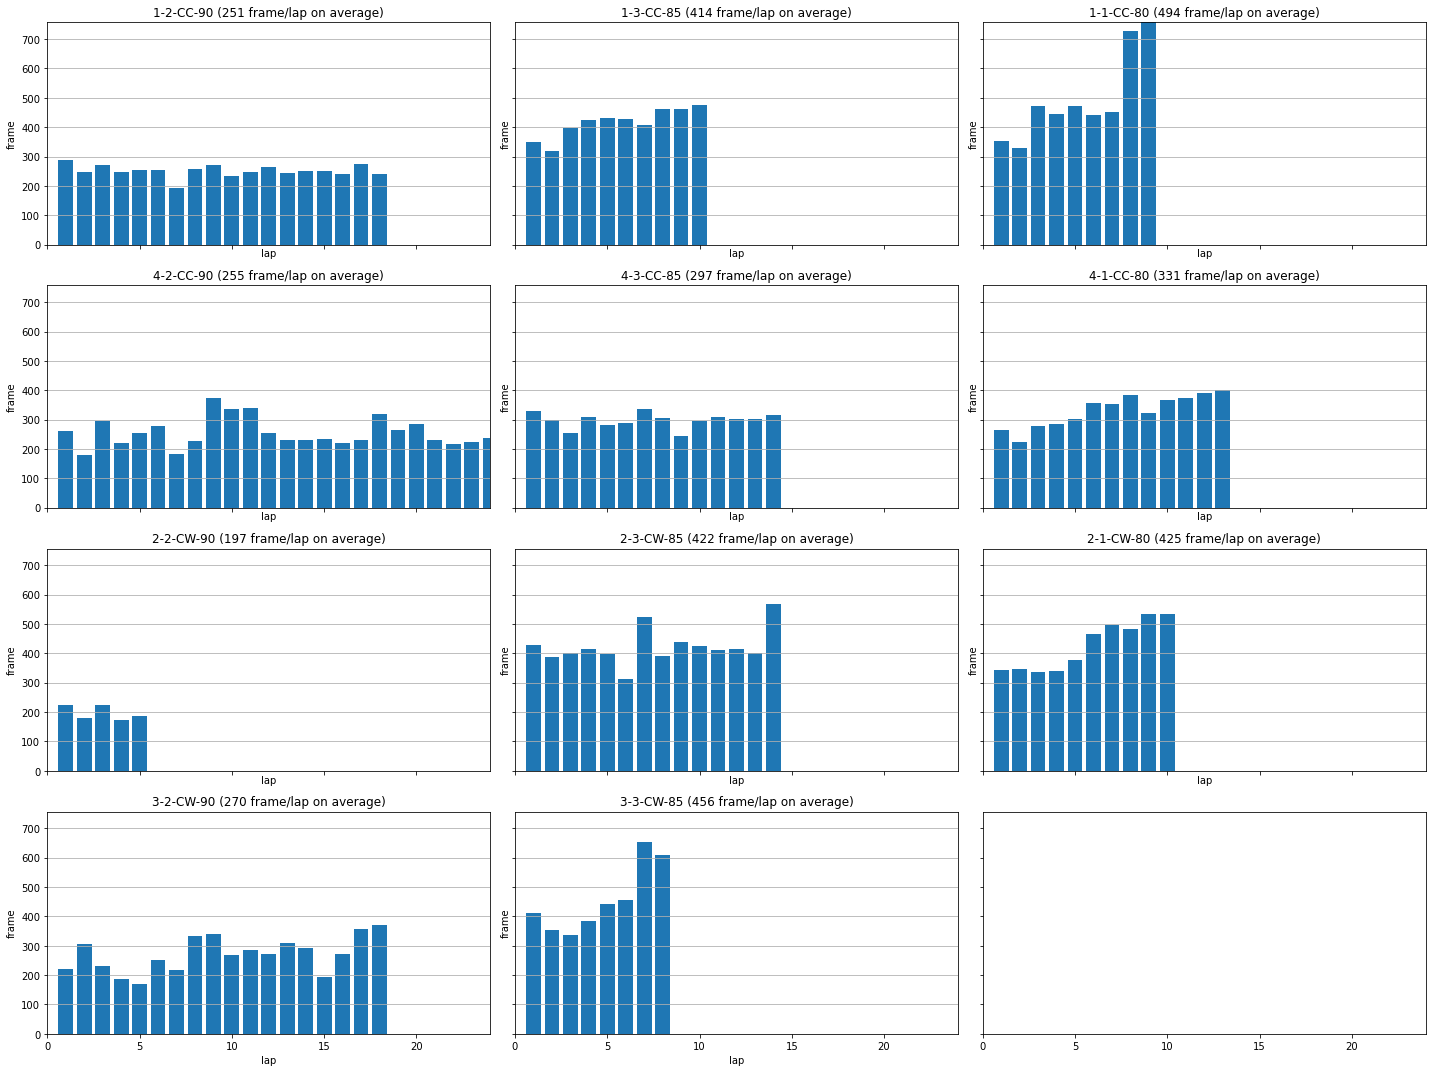

In [78]:
max_frames_per_lap = max([max(tub) for tub in lengths_counts])
max_laps = max([len(tub) for tub in lengths_counts])

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 15), sharex='all', sharey='all')

for (name, (lower_bound, upper_bound)), ax in zip(tub_bounds, axs.flat):
    images = tub_images[name]
    diffs = get_diffs(images)
    counts = get_counts(diffs, lower_bound, upper_bound)
    lengths = get_lengths(counts)
    ax.grid(True, axis='y')
    ax.set(title=f'{name} ({average_lap_frames[name]} frame/lap on average)', xlabel='lap', ylabel='frame')
    ax.bar(range(1, len(lengths)+1), lengths)

ax.set(ylim=(0, max_frames_per_lap), xlim=(0, max_laps))
fig.tight_layout()
plt.show()

## Are the ground truth turning angles more extreme for with higher speeds?
### Load ground truth angles

In [22]:
def load_tub_angles(tub_path, cfg):
    return [r.underlying['user/angle'] for r in load_tub_records(tub_path, cfg)]

tub_angles = {}
for tub_path in tubs:
    full_path = 'data/' + tub_path
    angles = load_tub_angles(full_path, cfg)
    tub_angles[tub_path] = angles   

Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/1-1-CC-80/catalog_4.catalog
Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/1-2-CC-90/catalog_4.catalog
Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/1-3-CC-85/catalog_4.catalog
Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/2-1-CW-80/catalog_4.catalog
Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/2-2-CW-90/catalog_2.catalog
Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/2-3-CW-85/catalog_6.catalog
Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/3-2-CW-90/catalog_6.catalog
Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/3-3-CW-85/catalog_4.catalog
Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/4-1-CC-80/catalog_5.catalog
Using catalog /User

### How many data points are there per specific direction?

CC - Counter Clockwise and CW - ClockWise
Speeds: 80, 85 and 90

In [79]:
from collections import defaultdict
dir_speed_counts = defaultdict(int)
for k, v in tub_angles.items():
    dir_speed_counts[k[-5:]] += len(v)


dir_speed_counts = list(dir_speed_counts.items())
dir_speed_counts.sort()
dir_speed_counts

[('CC-80', 9193),
 ('CC-85', 8678),
 ('CC-90', 10799),
 ('CW-80', 4433),
 ('CW-85', 10098),
 ('CW-90', 6482)]

Let's demonstrate that higher speeds have more extreme ground truth turning angles.

In [84]:
from collections import OrderedDict
from matplotlib import pyplot as plt

def get_angles_for_direction(tub_angles, direction):
    direction_tub_angles = {k: v for k, v in tub_angles.items() if direction in k}
    direction_tub_angles = OrderedDict(sorted(list(direction_tub_angles.items()), key=lambda k: k[0][-2:]))
    direction_angles_by_speed = OrderedDict()
    for k, v in direction_tub_angles.items():
        if direction_angles_by_speed.get(k[-2:]):
            direction_angles_by_speed[k[-2:]].extend(v)
        else:
            direction_angles_by_speed[k[-2:]] = v
    return direction_angles_by_speed

def plot_all(name, tub_angles):
    plt.figure()
    hist, bins, _ = plt.hist(tub_angles.values(), bins=9, density=True)
    plt.title(name)
    plt.legend(tub_angles.keys())
    plt.xlabel('angle')
    plt.ylabel('count')
    plt.grid()
    plt.show()
    return hist

### Counter clockwise direction histogram

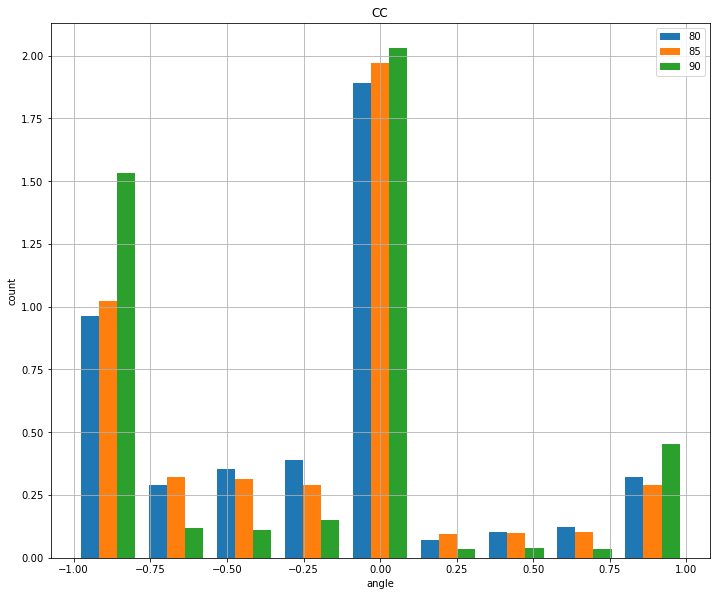

In [86]:
direction = 'CC'
hist = plot_all(direction, get_angles_for_direction(tub_angles, direction))

### Clockwise direction histogram

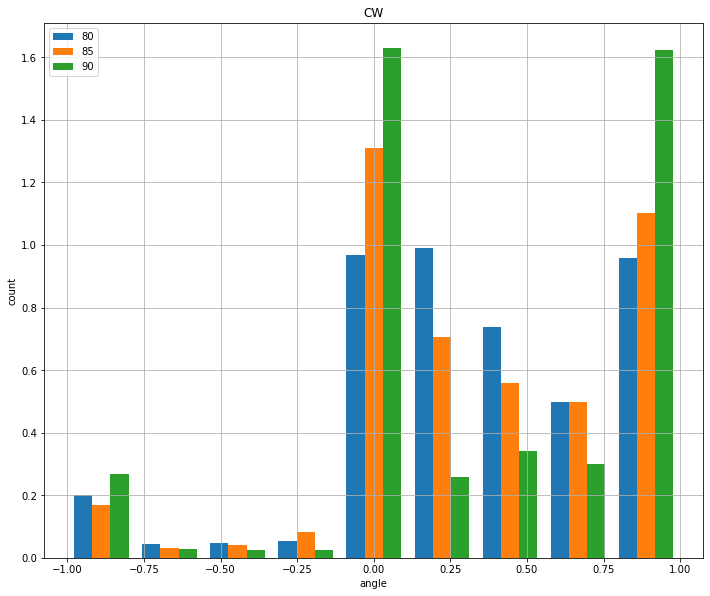

In [87]:
direction = 'CW'
hist = plot_all(direction, get_angles_for_direction(tub_angles, direction))